# Grid search with nested CV

In [3]:
# TODO: to be deleted
import os
path = '/Users/yeganeh/Codes/SuggNet'
os.chdir(path) 

In [2]:
%reload_ext autoreload
%autoreload 3

from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold, cross_val_score,
                                     KFold, StratifiedKFold, StratifiedShuffleSplit)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import SVC, LinearSVC
from src.suggnet.pipeline import FeatureExtractor

In [5]:
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')

# DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [3]:
# create a list of combination of kinds and frequency bands.
kinds = ['correlation source', 'power source', 'power sensor',
        'plv source', 'correlation sensor', 'plv sensor']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]

In [10]:
cv_scores = []
best_estimators = []
importances = []
models_test_accuraies = {}

# Choose cross-validation techniques for the inner and outer loops,
outer_cv = GroupShuffleSplit(n_splits=20, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)

models
for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    # 2. PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', 'passthrough'),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # 3. grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
        'select': [SelectFromModel(SVC(max_iter=1000000, kernel='linear')), 'passthrough'],
        'clf__C': [0.1, 0.5, 1, 5, 10, 50, 100],
    }]
    
    test_accuraies = []
    for train, test in outer_cv.split(X, y, groups):

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        test_accuraies.append((y[test] == y_pred).mean())
    
    models_test_accuraies[model_name] = test_accuraies

# pd.DataFrame(models_test_accuraies).to_csv('data/classification_results/nested_grid_results.csv')

  0%|          | 0/7 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>correlation sensor (beta)<<<<<<<<<<<<<<<<<<


 14%|█▍        | 1/7 [10:07<1:00:43, 607.17s/it]

>>>>>>>>>>>>>>>>>correlation sensor (gamma)<<<<<<<<<<<<<<<<<<


 29%|██▊       | 2/7 [20:14<50:37, 607.45s/it]  

>>>>>>>>>>>>>>>>>plv sensor (delta)<<<<<<<<<<<<<<<<<<


 43%|████▎     | 3/7 [29:10<38:18, 574.50s/it]

>>>>>>>>>>>>>>>>>plv sensor (theta)<<<<<<<<<<<<<<<<<<


 57%|█████▋    | 4/7 [38:10<28:02, 560.84s/it]

>>>>>>>>>>>>>>>>>plv sensor (alpha)<<<<<<<<<<<<<<<<<<


 71%|███████▏  | 5/7 [47:06<18:23, 551.89s/it]

>>>>>>>>>>>>>>>>>plv sensor (beta)<<<<<<<<<<<<<<<<<<


 86%|████████▌ | 6/7 [56:01<09:06, 546.30s/it]

>>>>>>>>>>>>>>>>>plv sensor (gamma)<<<<<<<<<<<<<<<<<<


100%|██████████| 7/7 [1:05:00<00:00, 557.26s/it]


## Classifications with nestet CV and without hyperparameter tuning

In [17]:
kinds = ['power sensor']
frequency_bands = ['gamma']
models = [(i, j) for i in kinds for j in frequency_bands]

In [18]:
cv_scores = []
best_estimators = []
importances = []
models_test_accuraies = {}
y_preds = []

# Choose cross-validation techniques for the inner and outer loops
outer_cv = GroupShuffleSplit(n_splits=50, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)


for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
    }]
    
    test_accuraies = []
    for train, test in outer_cv.split(X, y, groups):

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        y_preds.append(y_pred)
        test_accuraies.append((y[test] == y_pred).mean())
    
    models_test_accuraies[model_name] = test_accuraies

# pd.DataFrame(models_test_accuraies).to_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv')

  0%|          | 0/1 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>power sensor (gamma)<<<<<<<<<<<<<<<<<<


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


### Significancy test
#### permutation test

In [23]:
from sklearn.model_selection import permutation_test_score

In [48]:
# create a list of combination of kinds and frequency bands.
kinds = ['correlation source', 'correlation sensor', 'wpli source',
         'wpli sensor', 'power source', 'power sensor']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]

CHANCE_CV = GroupShuffleSplit(n_splits=5, test_size=0.2)

In [ ]:
## permutation + no nested
perm_scores = {}

for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    pipe = Pipeline([
            ('extract', FeatureExtractor(kind=kind, frequency_band=frequency_band)),
            ('zerovar', VarianceThreshold(threshold=0.0)),
            ('scale', StandardScaler()),
            ('clf', SVC(kernel='linear'))
        ])


    perm_score = permutation_test_score(pipe, X, y, cv=CHANCE_CV, scoring='accuracy',
                                         n_permutations=100, n_jobs=-1, verbose=0,
                                         groups=groups)
    
    perm_scores[model_name] = perm_score

chance_scores = {k:v[1] for k,v in perm_scores.items()}
# pd.DataFrame(chance_scores).to_csv('data/classification_results/chance model/perm_score.csv')
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

In [69]:
grid_results = pd.read_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv', index_col=0)

# remove plv results
col = [i for i in grid_results.columns if 'plv' in i]
grid_results.drop(columns=col, inplace=True)

grid_results = grid_results.melt()

# chance score
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

#### manual permutation test

In [42]:
import random
# create a list of combination of kinds and frequency bands.
kinds = ['correlation source', 'correlation sensor', 'wpli source',
         'wpli sensor', 'power source', 'power sensor']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]

In [ ]:
# chance score
cv_scores = []
best_estimators = []
importances = []
models_test_accuraies = {}
y_preds = []

# Choose cross-validation techniques for the inner and outer loops
outer_cv = GroupShuffleSplit(n_splits=50, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)


for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
    }]
    
    test_accuraies = []
    
    for train, test in outer_cv.split(X, y, groups):
        random.shuffle(y)

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        y_preds.append(y_pred)
        test_accuraies.append((y[test] == y_pred).mean())
    
    models_test_accuraies[model_name] = test_accuraies

# pd.DataFrame(models_test_accuraies).to_csv('data/classification_results/chance model/perm_score_manually_shuffled.csv')
chance_scores = pd.DataFrame(models_test_accuraies).melt(var_name='label', value_name='test_score')

In [47]:
grid_results = pd.read_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv', index_col=0)

# remove plv results
col = [i for i in grid_results.columns if 'plv' in i]
grid_results.drop(columns=col, inplace=True)

grid_results = grid_results.melt()

#### Visualization

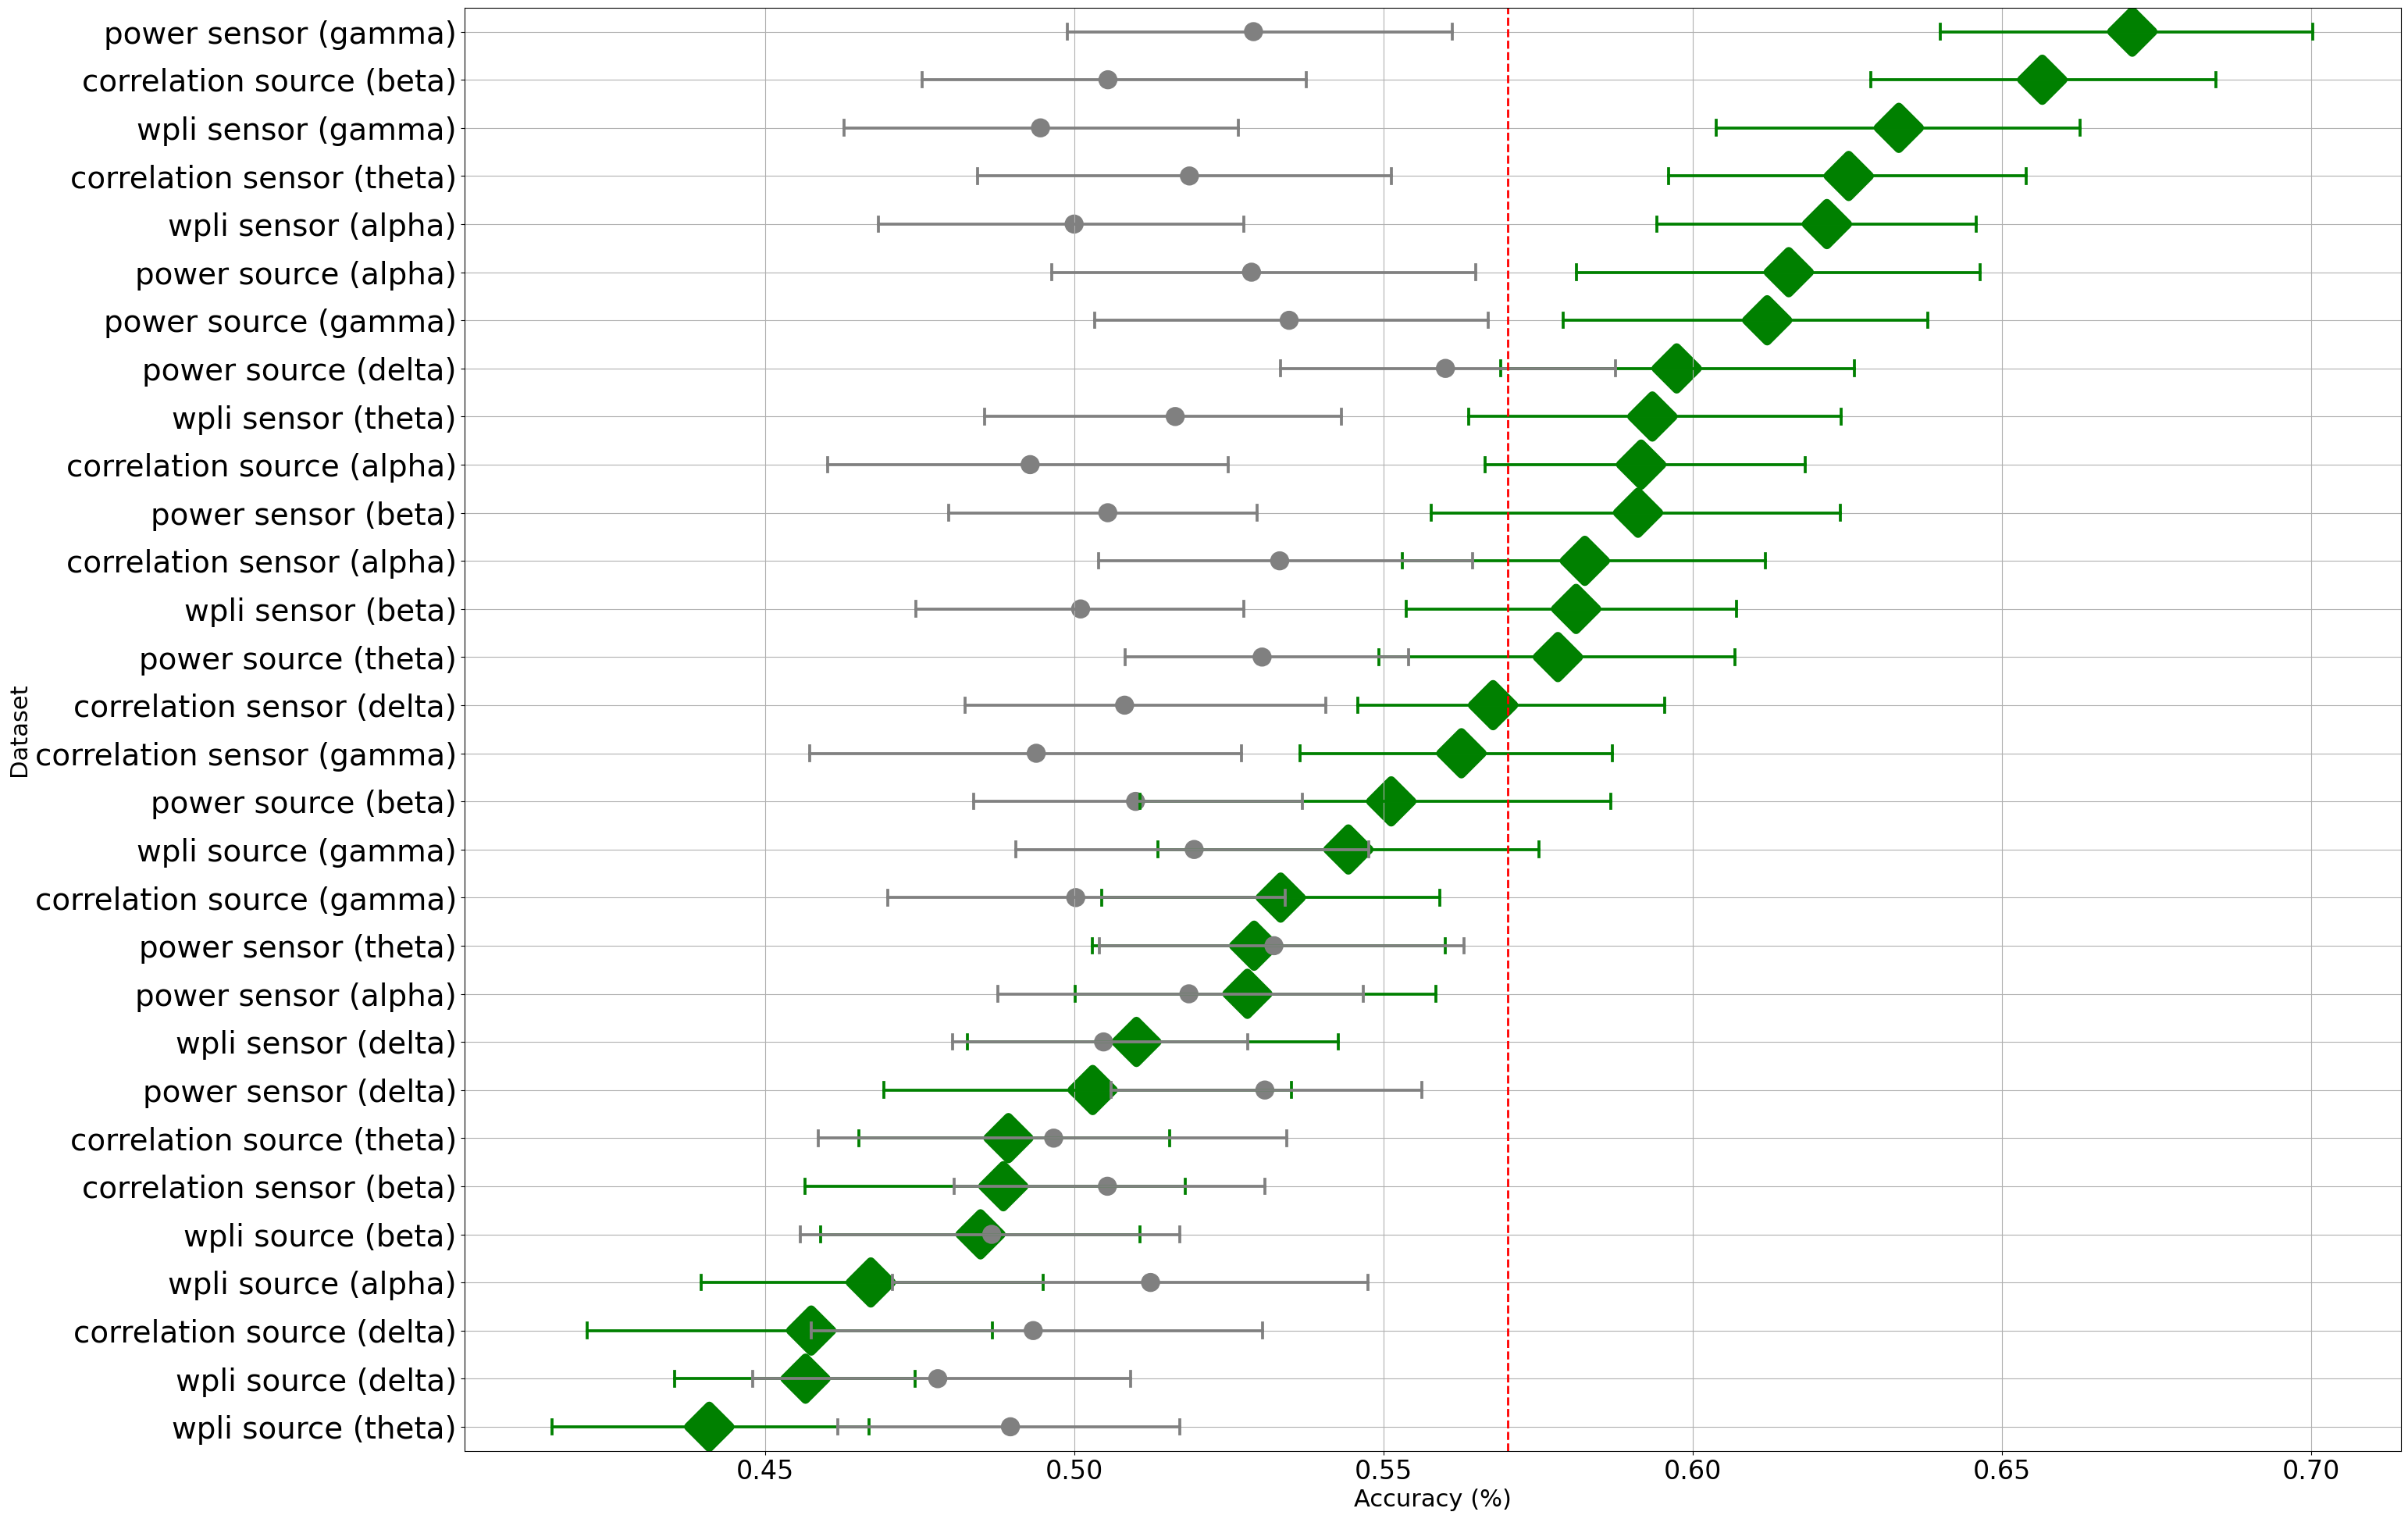

In [55]:
order = grid_results.groupby('variable')['value'].mean().sort_values(ascending=False).index.values

_, ax = plt.subplots(1, 1, figsize=(32, 24))

# plot observed
# sns.stripplot(data=grid_results, x='value', y='variable', orient='h', order=order)
sns.pointplot(data=grid_results, x='value', y='variable', order=order, orient='h', markers='D',
              color='green', scale=4, capsize=0.3, join=False, label='Accuracy', dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

# plot chance
# sns.boxplot(data=chance_scores, x='test_score', y='label', saturation=1, orient='h', order=order)
sns.pointplot(data=chance_scores, x='test_score', y='label', order=order, orient='h',
              color='gray', scale=2, capsize=0.3, join=False, label='Chance', dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

plt.axvline(0.57, color='r', linestyle='--', linewidth=2)

plt.xticks(fontsize=24)
plt.yticks(fontsize=28)

plt.xlabel('Accuracy (%)', fontsize=22)
plt.ylabel('Dataset', fontsize=22)
plt.grid()
# plt.title('SVM Validation Accuracy (100x 5-fold CV)')

# plt.legend(loc="upper left")

plt.show()

### model agnosis explanation

In [2]:
from sklearn.inspection import permutation_importance
from collections import defaultdict
import shap
import ast
from tqdm.auto import tqdm

CV_EXPLAIN = StratifiedGroupKFold(n_splits=5, shuffle=True)
n_iterations = 40

In [ ]:
models = [('power sensor', 'gamma'),
        #   ('correlation source', 'beta')
          ]
shap_values = {}
y_tests = {}
y_preds = {}
test_indices = {}

# PIPELINE
pipe = Pipeline(steps=[
('extract', FeatureExtractor()),
('zerovar', VarianceThreshold(threshold=0.0)),
('scale', StandardScaler()),
('clf', SVC(max_iter=1000000, kernel='linear')),
])


for m in models:
    
    # set params
    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    params = {
        'extract__kind': kind,
        'extract__frequency_band': frequency_band,
    }
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    pipe.set_params(**params)

    # fit model
    X_t = pipe[:-1].fit_transform(X, y)
    feature_names = pipe[:-1].get_feature_names_out()
    model_shapes = []
    _test_indices = []
    y_test_cv = []
    y_pred_cv = []

    for iter in tqdm(range(n_iterations), desc=model_name):
        for train, test in CV_EXPLAIN.split(X, y, groups=groups):

            model = pipe[-2:].fit(X_t[train], y[train])
            y_pred = model.predict(X_t[test])
            
            _test_indices.extend(test)
            y_test_cv.append(y[test])
            y_pred_cv.append(y_pred)
            
            explainer = shap.Explainer(model.predict, X_t[train], feature_names=feature_names)
            cv_shap_values = explainer(X_t[test], max_evals=len(feature_names)*2+1)
            model_shapes.append(cv_shap_values)
            
    
    y_tests[model_name] = np.hstack(y_test_cv)
    y_preds[model_name] = np.hstack(y_pred_cv)
    test_indices[model_name] = np.array(_test_indices)
    
    shap_values[model_name] = shap.Explanation(
        values=np.vstack([sh.values for sh in model_shapes]),
        base_values=np.hstack([sh.base_values for sh in model_shapes]),
        data=np.vstack([sh.data for sh in model_shapes]),
        feature_names=feature_names,
        output_indexes=y_pred,
        output_names=['low', 'high']
    )
    
# shap_values = shap_values[model_name]

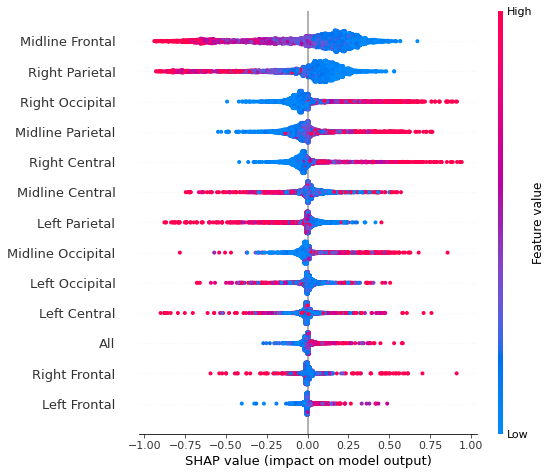

In [11]:
shap_values['power sensor (gamma)'].feature_names = ['Midline Central',
 'Midline Frontal',
 'Left Central',
 'Left Frontal',
 'Left Occipital',
 'Left Parietal',
 'Midline Occipital',
 'Midline Parietal',
 'Right Central',
 'Right Frontal',
 'Right Occipital',
 'Right Parietal',
 'All'
 ]
shap.summary_plot(shap_values['power sensor (gamma)'], plot_type='dot', max_display=15)

## Experimenting:
classification with real hypnosis sessions, regardless of their lables.

In [95]:
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('condition.str.contains("experience")')
# DATA = DATA.query('procedure == "confusion" or procedure == "relaxation"')
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('not procedure.str.contains("embedded")')

# DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [96]:
# 2. PIPELINE
pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear', class_weight='balanced')),
])

# CV method
CV = GroupShuffleSplit(n_splits=100, test_size=0.2)

# 3. Grid Search
grid_params = [{
    'extract__kind': ['correlation source', 'power source', 'power sensor',
                      'wpli source'],
    'extract__frequency_band': ['delta', 'theta', 'alpha', 'beta', 'gamma'],
}]

grid = GridSearchCV(pipe, grid_params, cv=CV, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X, y, groups=groups)

Fitting 100 folds for each of 20 candidates, totalling 2000 fits


GridSearchCV(cv=GroupShuffleSplit(n_splits=100, random_state=None, test_size=0.2,
         train_size=None),
             estimator=Pipeline(steps=[('extract', FeatureExtractor()),
                                       ('zerovar', VarianceThreshold()),
                                       ('scale', StandardScaler()),
                                       ('clf',
                                        SVC(class_weight='balanced',
                                            kernel='linear',
                                            max_iter=1000000))]),
             n_jobs=-1,
             param_grid=[{'extract__frequency_band': ['delta', 'theta', 'alpha',
                                                      'beta', 'gamma'],
                          'extract__kind': ['correlation source',
                                            'power source', 'power sensor',
                                            'wpli source']}],
             scoring='accuracy', verbose=1)

In [97]:
grid_results = pd.DataFrame(grid.cv_results_)
grid_results['label'] = grid_results['param_extract__kind'] + ' (' + grid_results['param_extract__frequency_band'] + ')'

# Sift out the best params (C and feature selections) for each model
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx]
grid_results.drop_duplicates(subset='label', inplace=True)

split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')

def fit_chance(model_name=None):
    """Utility function to simulate emperical chance level."""
    
    chance_model = DummyClassifier(strategy='most_frequent')
    chance_scores = cross_val_score(chance_model, X, y, groups=groups, cv=CV, scoring='accuracy', n_jobs=-1)
    return chance_scores

chance_scores = {}
for model_name in grid_results['label'].unique():
    model_chance_scores = fit_chance(model_name)
    chance_scores[model_name] = model_chance_scores.tolist()
    
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

Text(0, 0.5, 'Dataset')

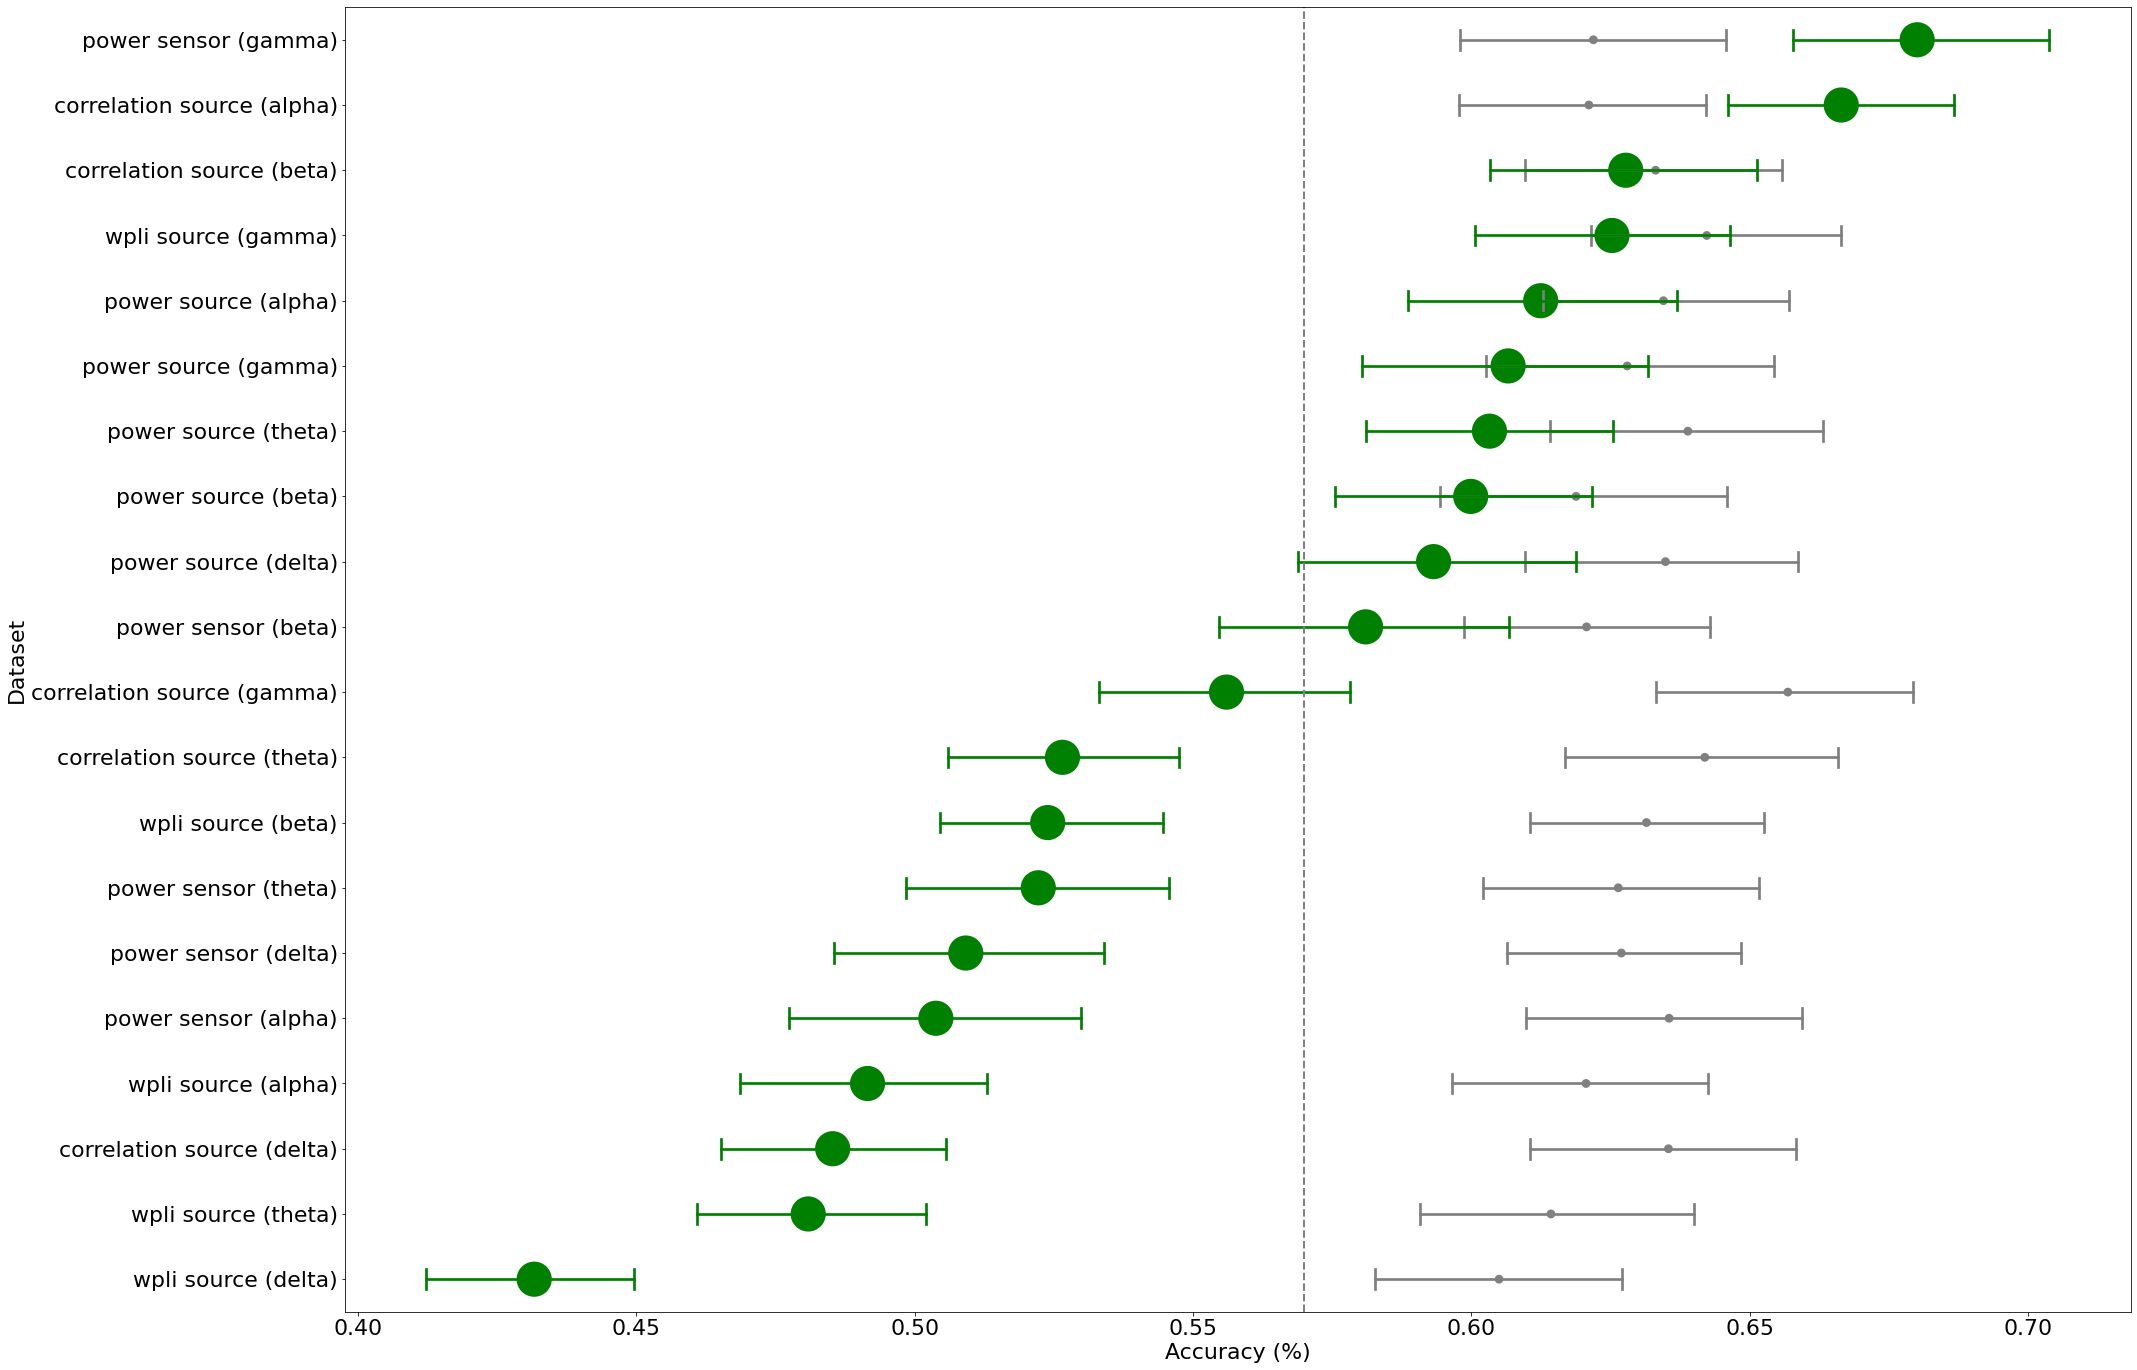

In [98]:
_, ax = plt.subplots(1, 1, figsize=(32, 24))
order = grid_results.groupby('label')['test_score'].mean().sort_values(ascending=False).index.values

# plot chance
sns.pointplot(data=chance_scores, x='test_score', y='label', order=order, orient='h',
              color='gray', scale=1, capsize=0.3, join=False, label='Chance', dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

# plot observed
sns.pointplot(data=grid_results, x='test_score', y='label', order=order, orient='h',
              color='green', scale=4, capsize=0.3, join=False, label='Accuracy', dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

# Add horizontal line indicating the baseline value
plt.axvline(0.57, color='grey', linestyle='--', linewidth=2)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlabel('Accuracy (%)', fontsize=22)
plt.ylabel('Dataset', fontsize=22)

In [15]:
import pickle

# open shap data 
with open('data/classification_results/shap_values.pkl', 'rb') as f:
    _shap_values = pickle.load(f)

# sift out shap, y_pred, y_test values
shap_keys = list(_shap_values.keys())[:3]
y_preds_keys = list(_shap_values.keys())[3:6]
y_test_keys = list(_shap_values.keys())[6:9]
test_indices_keys = list(_shap_values.keys())[9:12]

shap_values = {k:_shap_values[k] for k in shap_keys}
y_preds = {k[7:]:_shap_values[k] for k in y_preds_keys} # remove 'y_pred_'
y_tests = {k[7:]:_shap_values[k] for k in y_test_keys} # remove 'y_test_'
test_indices = {k[len('test_indices_'):]:_shap_values[k] for k in test_indices_keys} # remove 'test_indices_'

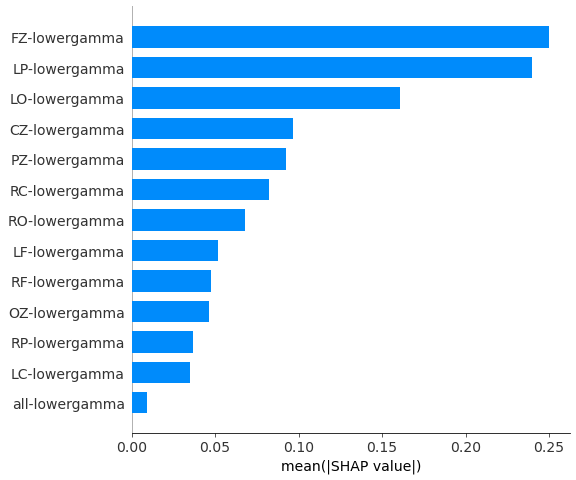

In [17]:
import shap
import matplotlib.pyplot as plt
model_name = 'power sensor (gamma)'
shap.summary_plot(shap_values[model_name], plot_type='bar', max_display=13, show=False)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('mean(|SHAP value|)', fontsize=14)
plt.show()